# Analyse du dataset

In [41]:
!pip install -q roboflow ultralytics pyyaml matplotlib

import warnings
warnings.filterwarnings('ignore')  # Désactive tous les warnings
import os
import yaml
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import pandas as pd

############################
# 1. Téléchargement dataset
############################

API_KEY = "fCQcZUpzybUUQxFuJtLc"  # Clé API Roboflow
rf = Roboflow(api_key=API_KEY)
project_chess = rf.workspace("edouard-rgh61").project("my-first-project-stbr2")
dataset_dir = "datasets/chess_dataset"  # Spécification du répertoire de téléchargement
os.makedirs(dataset_dir, exist_ok=True)  # Création du répertoire s'il n'existe pas
version_chess = project_chess.version(2)
dataset_chess = version_chess.download("yolov8")
print("Dataset Chess téléchargé dans My-First-Project-2")

# Chemin vers le YAML du dataset
data_yaml_path = "datasets/My-First-Project-2/data.yaml"
with open(data_yaml_path, "r") as f:
    chess_yaml = yaml.safe_load(f)
print(f"YAML du dataset chargé depuis {data_yaml_path}")

# Récupération des noms de classes
class_names = chess_yaml["names"]  # Liste des noms de classe
num_classes = len(class_names)
print(f"Le dataset contient {num_classes} classes : {class_names}")

############################
# 2. Analyse préalable du dataset
############################

train_images_dir = os.path.join("datasets/My-First-Project-2", "train", "images")
val_images_dir = os.path.join("datasets/My-First-Project-2", "valid", "images")
train_labels_dir = os.path.join("datasets/My-First-Project-2", "train", "labels")
val_labels_dir = os.path.join("datasets/My-First-Project-2", "valid", "labels")

# Nombre d'images train et valid
train_image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

print(f"\nNombre d'images d'entraînement : {len(train_image_files)}")
print(f"Nombre d'images de validation  : {len(val_image_files)}")

# Parcours des fichiers de labels (train + val) pour compter les occurrences
all_label_files = glob.glob(os.path.join(train_labels_dir, "*.txt")) + glob.glob(os.path.join(val_labels_dir, "*.txt"))

# Compteur global du nombre de boxes par classe
counts_per_class = [0] * num_classes

# Pour savoir combien d'images contiennent chaque classe
images_with_class = [set() for _ in range(num_classes)]

for label_file in all_label_files:
    # Nom de fichier sans extension pour associer avec l'image
    image_id = os.path.splitext(os.path.basename(label_file))[0]
    with open(label_file, "r") as lf:
        lines = lf.readlines()
        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            class_id = int(parts[0])
            counts_per_class[class_id] += 1
            images_with_class[class_id].add(image_id)

total_boxes = sum(counts_per_class)

# Préparation du tableau de statistiques
stats = []
for cls_id, cls_name in enumerate(class_names):
    n_boxes = counts_per_class[cls_id]
    n_images_with_cls = len(images_with_class[cls_id])
    percentage = (n_boxes / total_boxes * 100) if total_boxes > 0 else 0.0
    stats.append({
        "Classe": cls_name,
        "Nombre de pièces": n_boxes,
        "Nombre d'images": n_images_with_cls,
        "% sur le dataset": round(percentage, 2)
    })

df_stats = pd.DataFrame(stats)
print("\nDistribution des classes dans le dataset (train + val) :")
display(df_stats)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-2 in yolov8:: 100%|██████████| 3334/3334 [00:03<00:00, 937.83it/s] 


Dataset Chess téléchargé dans My-First-Project-2
YAML du dataset chargé depuis datasets/My-First-Project-2/data.yaml
Le dataset contient 12 classes : ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']

Nombre d'images d'entraînement : 1452
Nombre d'images de validation  : 105

Distribution des classes dans le dataset (train + val) :


Classe  Nombre de pièces  Nombre d'images  % sur le dataset
0   black-bishop               726              438              4.72
1     black-king               762              762              4.95
2   black-knight              1015              676              6.60
3     black-pawn              3592              778             23.34
4    black-queen               457              457              2.97
5     black-rook              1074              714              6.98
6   white-bishop               915              630              5.95
7     white-king               789              789              5.13
8   white-knight              1025              694              6.66
9     white-pawn              3438              780             22.34
10   white-queen               590              590              3.83
11    white-rook              1007              676              6.54

# Chargement du modèle Yolov8n entrainé et test:

In [45]:
from pathlib import Path
from ultralytics import YOLO

# Chemin exact vers le fichier last.pt produit par l'entraînement
current_dir = Path(os.getcwd())
data_yaml_path = "My-First-Project-2/data.yaml"  # Chemin relatif sans le préfixe datasets/
abs_data_yaml_path = str(current_dir / data_yaml_path)

# Corriger le chemin pour éviter la duplication du dossier datasets
abs_data_yaml_path = abs_data_yaml_path.replace('datasets\\datasets', 'datasets')
weights_path = "datasets/kaggle/run_exp0/weights/last.pt"
  

# Redéfinition du modèle à partir de ces poids
model = YOLO(weights_path)

# Vous pouvez ensuite réaliser une nouvelle validation, des prédictions, etc.
# Par exemple :
val_results_new = model.val(data=data_yaml_path, verbose=False)

Ultralytics 8.3.85  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-6820HQ 2.70GHz)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\levovo pro p50\Documents\informatique\MALIA\Recent advance in IA\datasets\My-First-Project-2\valid\labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 441.18it/s]

val: WARNING  C:\Users\levovo pro p50\Documents\informatique\MALIA\Recent advance in IA\datasets\My-First-Project-2\valid\images\26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.2fd71518e5c85376b204823117294328.jpg: 1 duplicate labels removed
val: New cache created: C:\Users\levovo pro p50\Documents\informatique\MALIA\Recent advance in IA\datasets\My-First-Project-2\valid\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


                   all        105       1334      0.981      0.983      0.987      0.797
Speed: 2.0ms preprocess, 85.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val9



=== Résultats par classe ===


Classe  Nombre de pièces  Nombre d'images  % sur le dataset  \
0   black-bishop               726              438              4.72   
1     black-king               762              762              4.95   
2   black-knight              1015              676              6.60   
3     black-pawn              3592              778             23.34   
4    black-queen               457              457              2.97   
5     black-rook              1074              714              6.98   
6   white-bishop               915              630              5.95   
7     white-king               789              789              5.13   
8   white-knight              1025              694              6.66   
9     white-pawn              3438              780             22.34   
10   white-queen               590              590              3.83   
11    white-rook              1007              676              6.54   

    mAP50-95(B)  
0      0.743879  
1      0.852920  
2      0.761082  
3      0.777683  
4      0.832315  
5      0.799266  
6      0.784565  
7      0.861385  
8      0.804776  
9      0.764768  
10     0.802427  
11     0.773257

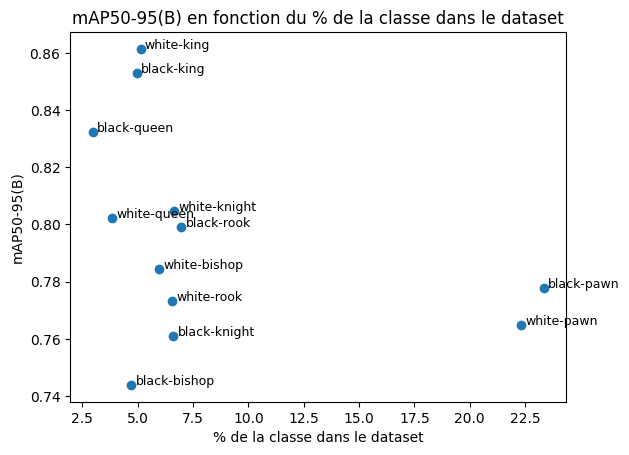

In [47]:
############################
# 4. Évaluation & analyse des résultats
############################

# Récupération du mAP global et par classe
# En ultralytics>=8.0.0, val_results.box.map_per_class donne mAP50-95 par classe
try:
    map_per_class = val_results.box.map_per_class
except AttributeError:
    # Selon la version, il se peut que l'attribut soit différent
    # On tente un autre attribut
    map_per_class = val_results.box.maps  # Dans certaines versions antérieures

# Création d'une liste associant la classe et son mAP
class_map_list = []
for i, cls_name in enumerate(class_names):
    class_map_list.append({
        "Classe": cls_name,
        "mAP50-95(B)": map_per_class[i] if i < len(map_per_class) else 0.0
    })

df_map = pd.DataFrame(class_map_list)

# Fusion avec la distribution de la classe (pour % dataset)
df_merged = pd.merge(df_stats, df_map, on="Classe")
# df_merged contiendra : Classe, Nombre de pièces, Nombre d'images, % sur le dataset, mAP50-95(B)

print("\n=== Résultats par classe ===")
display(df_merged)

# Tracé de la courbe/diagramme mAP50-95(B) vs % de la classe dans le dataset
x = df_merged["% sur le dataset"].values
y = df_merged["mAP50-95(B)"].values
labels = df_merged["Classe"].values

plt.figure()
plt.scatter(x, y)
for i, lbl in enumerate(labels):
    plt.text(x[i] + 0.2, y[i], lbl, fontsize=9)
plt.xlabel("% de la classe dans le dataset")
plt.ylabel("mAP50-95(B)")
plt.title("mAP50-95(B) en fonction du % de la classe dans le dataset")
plt.show()

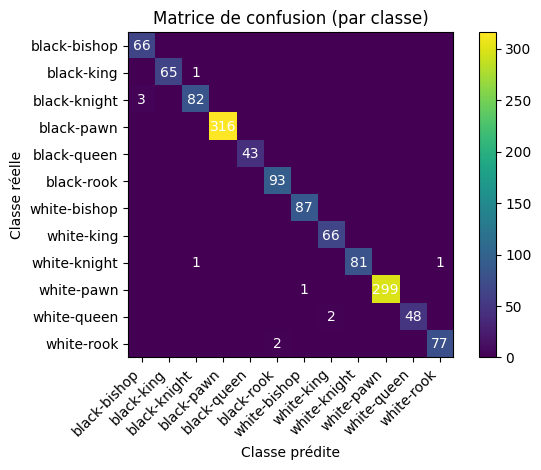

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def iou(boxA, boxB):
    """
    Calcule l'IoU (Intersection over Union) entre deux boîtes au format [x1, y1, x2, y2].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    if boxAArea == 0 or boxBArea == 0:
        return 0.0
    iou_val = interArea / float(boxAArea + boxBArea - interArea)
    return iou_val

def read_ground_truth_boxes_for_val(image_path):
    """
    Lit les boîtes réelles (ground truth) pour l'image spécifiée dans le répertoire de validation.
    Renvoie une liste de tuples (class_id, x1, y1, x2, y2) en coordonnées pixels.
    """
    filename_no_ext = os.path.splitext(os.path.basename(image_path))[0]
    label_file = os.path.join(val_labels_dir, filename_no_ext + ".txt")
    if not os.path.exists(label_file):
        return []
    
    # Lecture de l'image pour obtenir largeur/hauteur en pixels
    img_bgr = cv2.imread(image_path)
    h, w, _ = img_bgr.shape

    boxes = []
    with open(label_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id = int(parts[0])
            x_c = float(parts[1])
            y_c = float(parts[2])
            bw = float(parts[3])
            bh = float(parts[4])
            # Conversion YOLO -> xyxy (en pixels)
            x1 = int((x_c - bw/2) * w)
            y1 = int((y_c - bh/2) * h)
            x2 = int((x_c + bw/2) * w)
            y2 = int((y_c + bh/2) * h)
            boxes.append((class_id, x1, y1, x2, y2))
    return boxes

def plot_image_classification(image_path, preds, iou_threshold=0.5):
    """
    Affiche l'image avec :
    - Boîtes réelles en BLEU
    - Prédictions correctes en VERT (bonne classe + IoU >= iou_threshold)
    - Prédictions incorrectes en ROUGE
    """
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground Truth boxes
    gt_boxes = read_ground_truth_boxes_for_val(image_path)

    # Dessin des boîtes GT en BLEU
    for cls_id, x1_gt, y1_gt, x2_gt, y2_gt in gt_boxes:
        cv2.rectangle(img_rgb, (x1_gt, y1_gt), (x2_gt, y2_gt), (0, 0, 255), 2)  # BGR=(255,0,0) → BLEU en RGB

    # Pour chaque prédiction, on cherche si elle "correspond" à une GT (même classe + IoU >= iou_threshold)
    # On fera un matching simple "best IoU" ; si on en trouve une correspondante, c'est "correct", sinon "incorrect".
    used_gt_indices = set()
    for box in preds.boxes:
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
        pred_class = int(box.cls[0])
        conf = float(box.conf[0])

        best_iou = 0.0
        best_idx = -1
        for idx_gt, (cls_id_gt, x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
            if idx_gt not in used_gt_indices:  # on ne matche pas 2 preds sur la même GT
                iou_val = iou(pred_box_xyxy, [x1_gt, y1_gt, x2_gt, y2_gt])
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_idx = idx_gt

        # Vérification : classe + IoU
        if best_idx >= 0:
            gt_class, x1_gt, y1_gt, x2_gt, y2_gt = gt_boxes[best_idx]
            if (pred_class == gt_class) and (best_iou >= iou_threshold):
                color = (0, 255, 0)  # Vert pour correct
                used_gt_indices.add(best_idx)  # On marque cette GT comme utilisée
            else:
                color = (255, 0, 0)  # Rouge (en BGR, c'est un bleu pur, donc pour un rouge "affiché", on fait (0,0,255))
                color = (0, 0, 255)  # vrai rouge en BGR
        else:
            # Aucune GT correspondante
            color = (0, 0, 255)  # Rouge

        cv2.rectangle(
            img_rgb,
            (int(pred_box_xyxy[0]), int(pred_box_xyxy[1])),
            (int(pred_box_xyxy[2]), int(pred_box_xyxy[3])),
            color, 2
        )

    # Affichage
    plt.figure()
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Mauvaises classifications en rouge, bonnes en vert, GT en bleu")
    plt.show()

###############################
# 1) Construction de la matrice de confusion
###############################

num_classes = len(class_names)  # Nombre de classes
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

iou_threshold = 0.5

# Si vous n'avez pas déjà les prédictions pour l'ensemble des images de validation :
val_image_paths = [os.path.join(val_images_dir, f) for f in val_image_files]
predictions = model.predict(val_image_paths, verbose=False)

for img_path, result in zip(val_image_paths, predictions):
    gt_boxes = read_ground_truth_boxes_for_val(img_path)  
    # gt_boxes est une liste de tuples : (gt_class, x1, y1, x2, y2) en coordonnées pixels

    # Pour chaîner le matching, on crée un tableau pour savoir quelles prédictions sont déjà utilisées
    used_pred_indices = set()

    # 2) Pour chaque GT, on trouve la prédiction "la plus probable" (IoU max) si IoU >= iou_threshold
    for (gt_class, gx1, gy1, gx2, gy2) in gt_boxes:
        best_iou = 0.0
        best_pred_idx = -1
        best_pred_class = None

        for idx_pred, box in enumerate(result.boxes):
            if idx_pred in used_pred_indices:
                # On a déjà associé cette prédiction à une GT
                continue
            
            px1, py1, px2, py2 = box.xyxy[0]  # prédiction en xyxy
            pclass = int(box.cls[0])
            
            # Calcul IoU
            current_iou = iou(
                [float(px1), float(py1), float(px2), float(py2)],
                [gx1, gy1, gx2, gy2]
            )
            
            # On conserve la meilleure IoU si elle dépasse le threshold
            if current_iou > best_iou:
                best_iou = current_iou
                best_pred_idx = idx_pred
                best_pred_class = pclass

        # Si on a trouvé une prédiction correspondante
        if best_pred_idx >= 0 and best_iou >= iou_threshold:
            # On incrémente la case [classe_réelle, classe_prédite]
            confusion_matrix[gt_class, best_pred_class] += 1

            # On "verrouille" cette prédiction pour qu'elle ne soit pas réutilisée
            used_pred_indices.add(best_pred_idx)
        else:
            # GT non matchée : ne modifie pas la matrice NxN
            # (si vous voulez comptez le "missed detection", voir plus bas)
            pass


###############################
# 2) Affichage de la matrice de confusion
###############################

plt.figure()
plt.imshow(confusion_matrix, interpolation='nearest')
plt.title("Matrice de confusion (par classe)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)

# Pour ajouter les valeurs à l'intérieur des cases
# (attention, si la matrice est grande, cela peut être illisible)
for i in range(num_classes):
    for j in range(num_classes):
        val = confusion_matrix[i, j]
        if val > 0:
            plt.text(j, i, str(val), ha='center', va='center', color='white')

plt.colorbar()
plt.tight_layout()
plt.show()

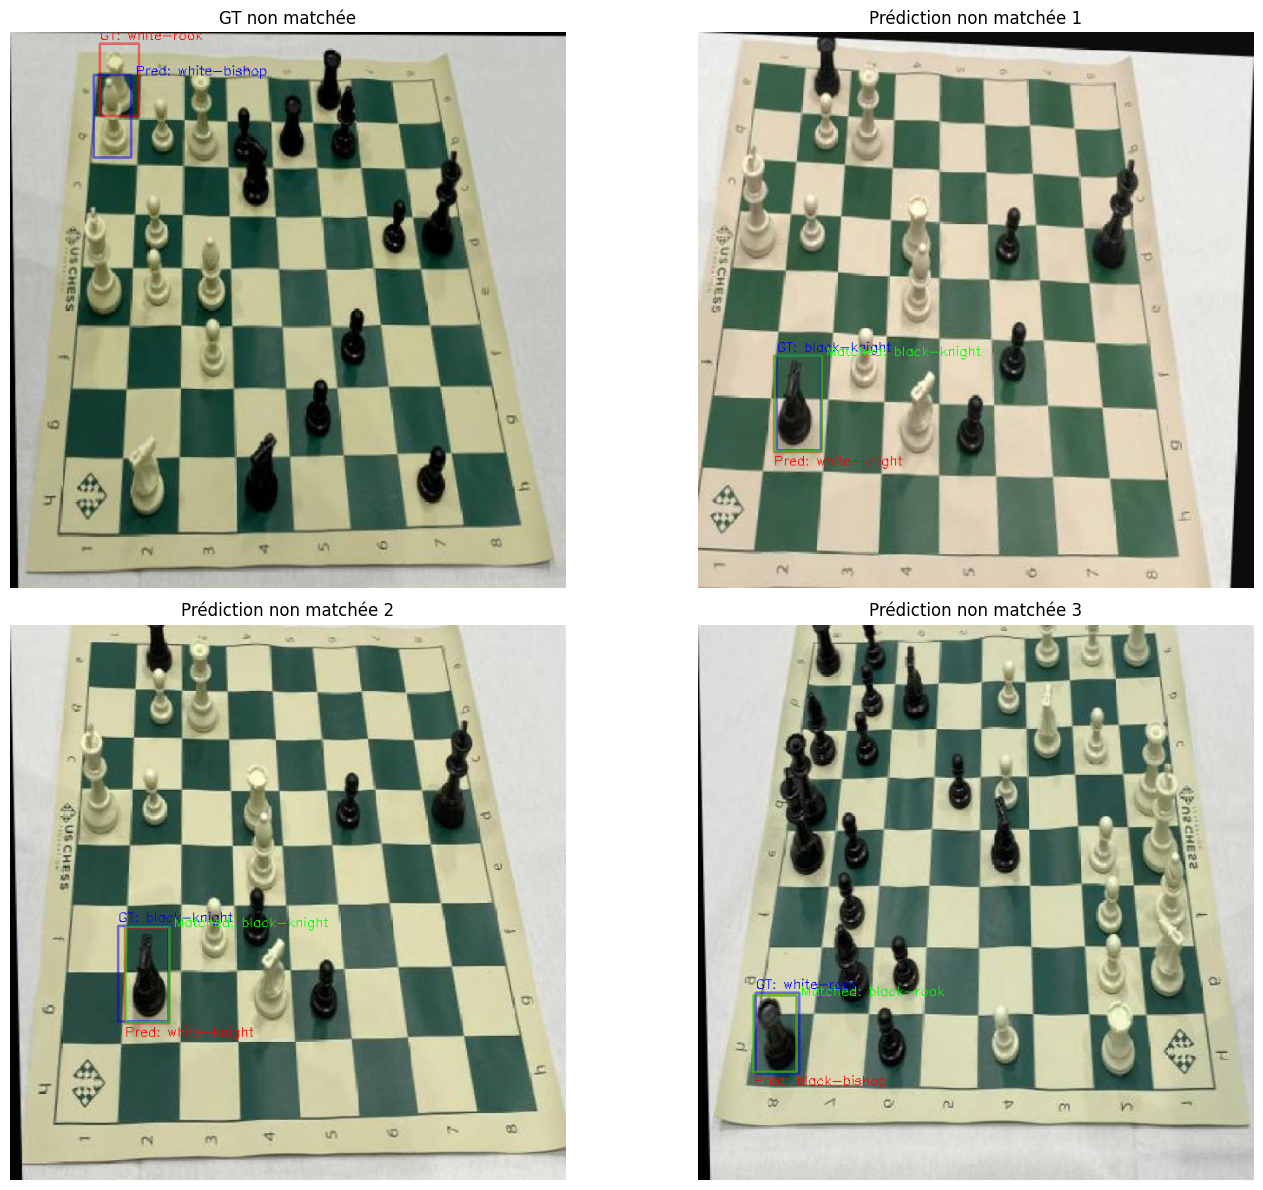

Nombre total de GT non matchées : 1
Nombre total de prédictions non matchées : 21


In [80]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Je suppose que vous avez déjà défini les fonctions iou() et read_ground_truth_boxes_for_val()
# ainsi que val_images_dir, val_image_files, model et class_names

iou_threshold = 0.5

# Chargement des images de validation et prédictions
val_image_paths = [os.path.join(val_images_dir, f) for f in val_image_files]
predictions = model.predict(val_image_paths, verbose=False)

# Statistiques et informations pour la visualisation
unmatched_gt_count = 0
unmatched_pred_count = 0
gt_matches = {}  # Pour stocker les correspondances {img_path: {gt_idx: pred_idx}}
pred_matches = {}  # Pour stocker les correspondances {img_path: {pred_idx: gt_idx}}

# Informations sur les éléments non matchés pour visualisation
unmatched_gt_info = []  # Stocke (img_path, gt_idx, best_pred_idx, best_iou)
unmatched_pred_info = []  # Stocke (img_path, pred_idx, best_gt_idx, best_iou)

# 1) Analyse de toutes les images pour trouver les matchs et non-matchs
for img_path, result in zip(val_image_paths, predictions):
    gt_boxes = read_ground_truth_boxes_for_val(img_path)
    
    # Initialiser les dictionnaires de correspondance pour cette image
    gt_matches[img_path] = {}
    pred_matches[img_path] = {}
    
    used_pred_indices = set()
    matched_gt_indices = set()
    
    # Pour chaque GT, trouver la meilleure prédiction correspondante
    for gt_idx, (gt_class, gx1, gy1, gx2, gy2) in enumerate(gt_boxes):
        best_iou = 0.0
        best_pred_idx = -1
        
        for pred_idx, box in enumerate(result.boxes):
            if pred_idx in used_pred_indices:
                continue
                
            px1, py1, px2, py2 = box.xyxy[0]
            current_iou = iou(
                [float(px1), float(py1), float(px2), float(py2)],
                [gx1, gy1, gx2, gy2]
            )
            
            if current_iou > best_iou:
                best_iou = current_iou
                best_pred_idx = pred_idx
        
        # Si on a trouvé une correspondance valide (IoU >= seuil)
        if best_pred_idx >= 0 and best_iou >= iou_threshold:
            used_pred_indices.add(best_pred_idx)
            matched_gt_indices.add(gt_idx)
            
            # Enregistrer la correspondance dans les deux sens
            gt_matches[img_path][gt_idx] = best_pred_idx
            pred_matches[img_path][best_pred_idx] = gt_idx
        else:
            # GT non matchée
            unmatched_gt_count += 1
            unmatched_gt_info.append((img_path, gt_idx, best_pred_idx, best_iou))
    
    # Les prédictions non matchées sont celles qui n'ont pas été utilisées
    all_pred_indices = set(range(len(result.boxes)))
    unmatched_pred_indices = all_pred_indices - used_pred_indices
    unmatched_pred_count += len(unmatched_pred_indices)
    
    # Pour chaque prédiction non matchée, trouver la GT qui lui correspond le mieux
    for pred_idx in unmatched_pred_indices:
        box = result.boxes[pred_idx]
        px1, py1, px2, py2 = box.xyxy[0]
        
        best_iou = 0.0
        best_gt_idx = -1
        
        for gt_idx, (gt_class, gx1, gy1, gx2, gy2) in enumerate(gt_boxes):
            current_iou = iou(
                [float(px1), float(py1), float(px2), float(py2)],
                [gx1, gy1, gx2, gy2]
            )
            
            if current_iou > best_iou:
                best_iou = current_iou
                best_gt_idx = gt_idx
        
        unmatched_pred_info.append((img_path, pred_idx, best_gt_idx, best_iou))

# Fonction pour dessiner un rectangle transparent
def draw_transparent_rectangle(img, pt1, pt2, color, alpha=0.5):
    overlay = np.zeros_like(img, dtype=np.uint8)
    cv2.rectangle(overlay, pt1, pt2, color, 2)
    mask = np.any(overlay != [0, 0, 0], axis=2)
    blended = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)
    img = np.where(mask[:, :, None], blended, img)
    return img

# 2) Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Afficher une GT non matchée
if unmatched_gt_info:
    img_path, gt_idx, best_pred_idx, best_iou = unmatched_gt_info[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt_boxes = read_ground_truth_boxes_for_val(img_path)
    result = next(p for p_img, p in zip(val_image_paths, predictions) if p_img == img_path)
    
    # Afficher la GT non matchée en bleu transparent
    gt_class, gx1, gy1, gx2, gy2 = gt_boxes[gt_idx]
    img = draw_transparent_rectangle(img, (gx1, gy1), (gx2, gy2), (255, 0, 0), alpha=0.5)
    gt_label = class_names[gt_class] if class_names else f"C{gt_class}"
    cv2.putText(img, f"GT: {gt_label}", (gx1, gy1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    # Afficher la prédiction avec le meilleur IoU en vert transparent
    if best_pred_idx >= 0:
        box = result.boxes[best_pred_idx]
        px1, py1, px2, py2 = box.xyxy[0]
        pred_class = int(box.cls[0])
        img = draw_transparent_rectangle(img, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), alpha=0.5)
        pred_label = class_names[pred_class] if class_names else f"C{pred_class}"
        # Label à droite de la boîte
        cv2.putText(img, f"Pred: {pred_label}", (int(px2) + 5, int(py1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    axes[0].imshow(img)
    axes[0].set_title(f"GT non matchée")
    axes[0].axis('off')

# Afficher jusqu'à 3 prédictions non matchées
for j in range(min(3, len(unmatched_pred_info))):
    if j < len(axes) - 1:  # S'assurer qu'il y a assez d'axes pour l'affichage
        img_path, pred_idx, best_gt_idx, best_iou = unmatched_pred_info[j]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        gt_boxes = read_ground_truth_boxes_for_val(img_path)
        result = next(p for p_img, p in zip(val_image_paths, predictions) if p_img == img_path)
        
        # Afficher la prédiction non matchée en rouge transparent
        box = result.boxes[pred_idx]
        px1, py1, px2, py2 = box.xyxy[0]
        pred_class = int(box.cls[0])
        img = draw_transparent_rectangle(img, (int(px1), int(py1)), (int(px2), int(py2)), (255, 0, 0), alpha=0.5)
        pred_label = class_names[pred_class] if class_names else f"C{pred_class}"
        # Label en bas de la boîte
        cv2.putText(img, f"Pred: {pred_label}", (int(px1), int(py2) + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Afficher la GT correspondante en vert transparent
        if best_gt_idx >= 0 and len(gt_boxes) > 0:
            gt_class, gx1, gy1, gx2, gy2 = gt_boxes[best_gt_idx]
            img = draw_transparent_rectangle(img, (gx1, gy1), (gx2, gy2), (0, 0, 255), alpha=0.5)
            gt_label = class_names[gt_class] if class_names else f"C{gt_class}"
            # Label en haut de la boîte
            cv2.putText(img, f"GT: {gt_label}", (gx1, gy1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            
            # Afficher aussi la prédiction qui a été associée à cette GT (si elle existe)
            if best_gt_idx in gt_matches[img_path]:
                matched_pred_idx = gt_matches[img_path][best_gt_idx]
                matched_box = result.boxes[matched_pred_idx]
                mx1, my1, mx2, my2 = matched_box.xyxy[0]
                matched_class = int(matched_box.cls[0])
                img = draw_transparent_rectangle(img, (int(mx1), int(my1)), (int(mx2), int(my2)), (0, 255, 0), alpha=0.5)
                matched_label = class_names[matched_class] if class_names else f"C{matched_class}"
                # Label à droite de la boîte
                cv2.putText(img, f"Matched: {matched_label}", (int(mx2) + 5, int(my1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        axes[j+1].imshow(img)
        axes[j+1].set_title(f"Prédiction non matchée {j+1}")
        axes[j+1].axis('off')

plt.tight_layout()
plt.show()

print(f"Nombre total de GT non matchées : {unmatched_gt_count}")
print(f"Nombre total de prédictions non matchées : {unmatched_pred_count}")

On va afficher 4 image(s) avec le plus d'erreurs.


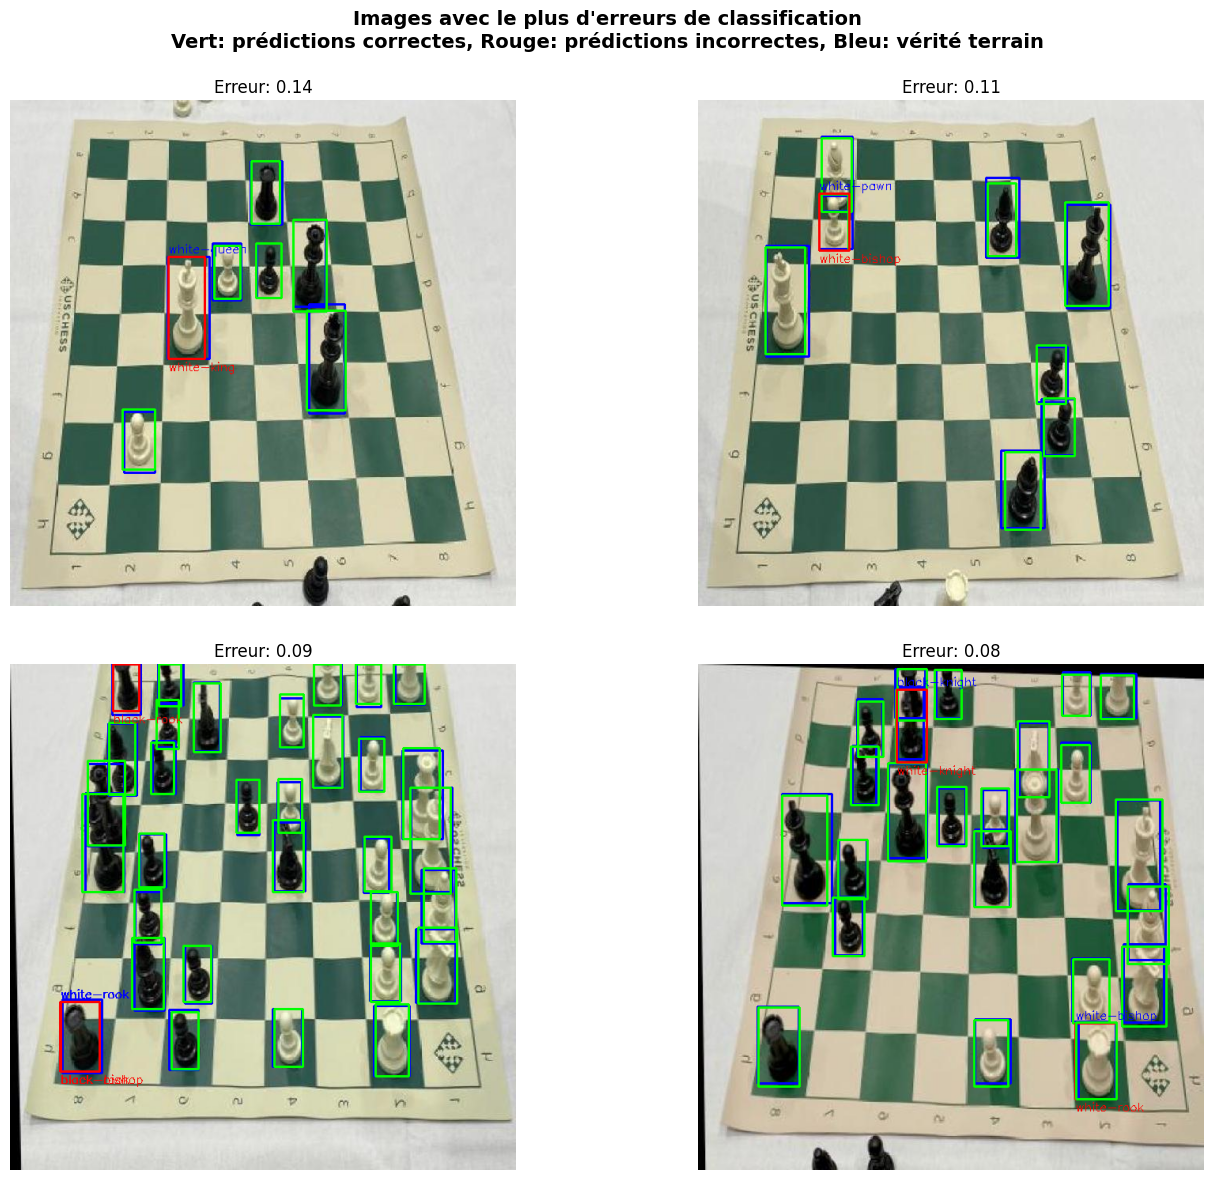

In [94]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
def plot_image_classification(ax, image_path, preds, iou_threshold=0.5, class_names=None):
    """
    Affiche l'image avec :
      - Boîtes réelles en BLEU
      - Prédictions correctes en VERT (classe OK + IoU >= iou_threshold)
      - Prédictions incorrectes en ROUGE
      - Affiche le vrai label en haut et le label prédit en bas
    """
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground Truth boxes
    gt_boxes = read_ground_truth_boxes_for_val(image_path)

    # Dessin des boîtes GT en BLEU
    for cls_id, x1_gt, y1_gt, x2_gt, y2_gt in gt_boxes:
        cv2.rectangle(img_rgb, (x1_gt, y1_gt), (x2_gt, y2_gt), (0, 0, 255), 2)  # Bleu

    # Pour chaque prédiction, rechercher la GT correspondante
    for box in preds.boxes:
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
        pred_class = int(box.cls[0])
        pred_label = class_names[pred_class] if class_names else f"C{pred_class}"

        # Recherche de la GT la plus proche (IoU max)
        best_iou_val = 0.
        best_gt_idx = -1
        for gt_idx, (gt_class, gx1, gy1, gx2, gy2) in enumerate(gt_boxes):
            iou_val = iou(pred_box_xyxy, [gx1, gy1, gx2, gy2])
            if iou_val > best_iou_val:
                best_iou_val = iou_val
                best_gt_idx = gt_idx

        # Détermination de la couleur et des labels
        if best_gt_idx >= 0 and best_iou_val >= iou_threshold:
            gt_class, _, _, _, _ = gt_boxes[best_gt_idx]
            gt_label = class_names[gt_class] if class_names else f"C{gt_class}"
            
            # Couleur de la boîte prédite selon si classe correcte ou non
            if pred_class == gt_class:
                color = (0, 255, 0)  # Vert pour correct
            else:
                color = (255, 0, 0)  # Rouge pour incorrect
                # Affichage des labels: vrai en haut, prédit en bas
                cv2.putText(img_rgb, gt_label, (int(pred_box_xyxy[0]), int(pred_box_xyxy[1])-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Bleu pour le vrai label
                
                # Couleur du label prédit selon si correct ou non
                pred_label_color = (0, 255, 0) if pred_class == gt_class else (255, 0, 0)
                cv2.putText(img_rgb, pred_label, (int(pred_box_xyxy[0]), int(pred_box_xyxy[3])+15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, pred_label_color, 1)
            
        else:
            # Pas de GT correspondante ou IoU trop faible
            color = (255, 0, 0)  # Rouge
            # Afficher uniquement le label prédit en bas (pas de vrai label)
            cv2.putText(img_rgb, pred_label, (int(pred_box_xyxy[0]), int(pred_box_xyxy[3])+15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Dessiner la boîte prédite
        cv2.rectangle(img_rgb,
                      (int(pred_box_xyxy[0]), int(pred_box_xyxy[1])),
                      (int(pred_box_xyxy[2]), int(pred_box_xyxy[3])),
                      color, 2)

    ax.imshow(img_rgb)
    ax.set_axis_off()
    ax.set_title(f"\nErreur: {err_rate:.2f}")

# 1) Prédictions sur l'ensemble des images de validation (si pas déjà fait).
val_image_paths = [os.path.join(val_images_dir, img) for img in val_image_files]
predictions = model.predict(val_image_paths, verbose=False)

# 2) Calcul d'un « taux d'erreur » pour chaque image
error_data = []
for img_path, result in zip(val_image_paths, predictions):
    gt_boxes = read_ground_truth_boxes_for_val(img_path)
    if len(gt_boxes) == 0 and len(result.boxes) == 0:
        # Ni GT ni prédiction, on considère 0 erreur
        error_data.append((img_path, result, 0.))
        continue

    n_pred = len(result.boxes)
    n_incorrect = 0

    # On fait un petit matching direct
    used_gt_indices = set()

    for box in result.boxes:
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
        pred_class = int(box.cls[0])

        best_iou_val = 0.
        best_gt_idx = -1
        for gt_idx, (gt_class, gx1, gy1, gx2, gy2) in enumerate(gt_boxes):
            if gt_idx not in used_gt_indices:
                iou_val = iou(pred_box_xyxy, [gx1, gy1, gx2, gy2])
                if iou_val > best_iou_val:
                    best_iou_val = iou_val
                    best_gt_idx = gt_idx

        if best_gt_idx >= 0:
            gt_class, gx1, gy1, gx2, gy2 = gt_boxes[best_gt_idx]
            if (pred_class != gt_class) or (best_iou_val < 0.5):
                # Mauvaise classe OU IoU trop faible
                n_incorrect += 1
            else:
                used_gt_indices.add(best_gt_idx)
        else:
            # Aucune GT correspondante
            n_incorrect += 1

    error_rate = n_incorrect / max(n_pred, 1)  # on normalise par le nb de prédictions
    error_data.append((img_path, result, error_rate))

# 3) Tri des images selon le taux d'erreur, décroissant
error_data_sorted = sorted(error_data, key=lambda x: x[2], reverse=True)

# 4) Sélectionnons 4 images avec le plus fort taux d'erreur dans une figure 2x2
num_to_display = 4
worst_images = error_data_sorted[1:num_to_display+1]

print(f"On va afficher {len(worst_images)} image(s) avec le plus d'erreurs.")

# Créer une figure avec 4 subplots disposés en 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()  # Aplatir pour faciliter l'indexation

# Afficher chaque image dans un subplot
for i, (img_path, pred, err_rate) in enumerate(worst_images):
    if i < num_to_display:
        plot_image_classification(axes[i], img_path, pred, iou_threshold=0.5, class_names=class_names)

fig.suptitle("Images avec le plus d'erreurs de classification\nVert: prédictions correctes, Rouge: prédictions incorrectes, Bleu: vérité terrain", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 1) Prédictions sur l'ensemble des images de validation (si pas déjà fait).
val_image_paths = [os.path.join(val_images_dir, img) for img in val_image_files]
predictions = model.predict(val_image_paths, verbose=False)

# 2) Calcul d'un « taux d'erreur » pour chaque image
error_data = []
for img_path, result in zip(val_image_paths, predictions):
    gt_boxes = read_ground_truth_boxes_for_val(img_path)
    if len(gt_boxes) == 0 and len(result.boxes) == 0:
        # Ni GT ni prédiction, on considère 0 erreur
        error_data.append((img_path, result, 0.))
        continue

    n_pred = len(result.boxes)
    n_incorrect = 0

    # On fait un petit matching direct
    used_gt_indices = set()

    for box in result.boxes:
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
        pred_class = int(box.cls[0])

        best_iou_val = 0.
        best_gt_idx = -1
        for gt_idx, (gt_class, gx1, gy1, gx2, gy2) in enumerate(gt_boxes):
            if gt_idx not in used_gt_indices:
                iou_val = iou(pred_box_xyxy, [gx1, gy1, gx2, gy2])
                if iou_val > best_iou_val:
                    best_iou_val = iou_val
                    best_gt_idx = gt_idx

        if best_gt_idx >= 0:
            gt_class, gx1, gy1, gx2, gy2 = gt_boxes[best_gt_idx]
            if (pred_class != gt_class) or (best_iou_val < 0.5):
                # Mauvaise classe OU IoU trop faible
                n_incorrect += 1
            else:
                used_gt_indices.add(best_gt_idx)
        else:
            # Aucune GT correspondante
            n_incorrect += 1

    error_rate = n_incorrect / max(n_pred, 1)  # on normalise par le nb de prédictions
    error_data.append((img_path, result, error_rate))


# Résultats Expérience 1: mAP50-95(B) en fonction du nombre d'époques pour différents nombre de couches gelées:

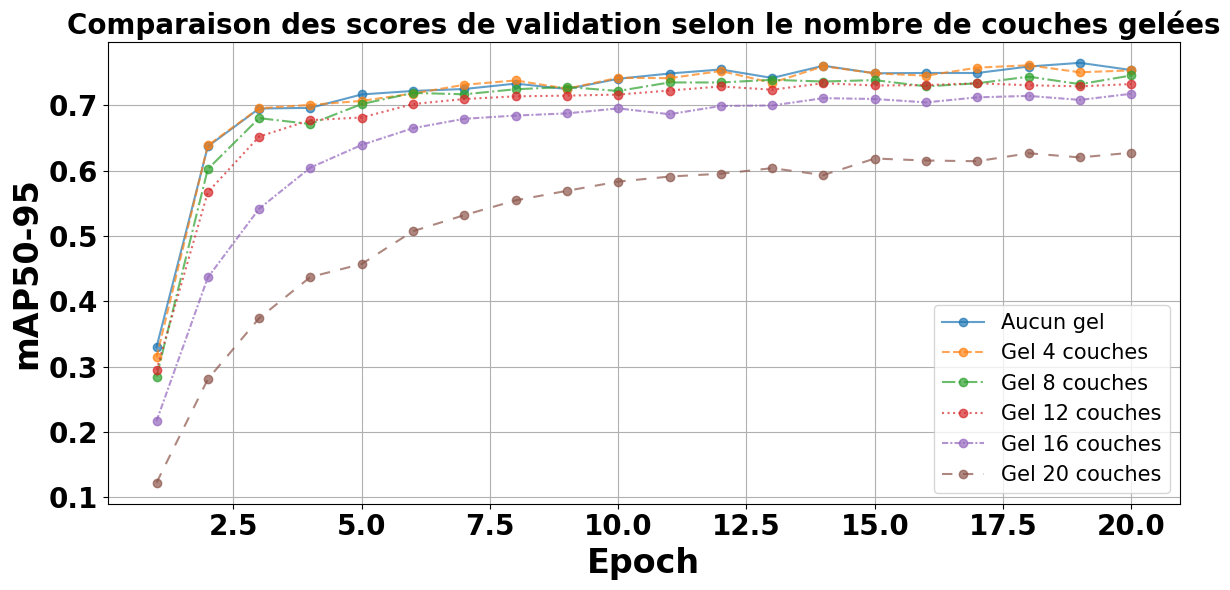

<Figure size 640x480 with 0 Axes>

In [90]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chemin vers le dossier principal contenant les résultats
base_path = "datasets/kaggle/runs_exp2/exp1_results"

# Recherche de tous les dossiers
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Dictionnaire pour stocker les résultats
results = {}

# Parcourir chaque dossier et extraire les données
for folder in folders:
    if folder == "Toutes sauf la dernière":
        continue
    csv_path = os.path.join(base_path, folder, "results.csv")
    
    if os.path.exists(csv_path):
        # Lire le fichier CSV
        df = pd.read_csv(csv_path)
        
        # Extraire les 20 premières époques (ou toutes si moins de 20)
        max_epoch = min(20, len(df))
        epochs = df['epoch'][:max_epoch].tolist()
        map_scores = df['metrics/mAP50-95(B)'][:max_epoch].tolist()
        
        # Stocker les résultats avec le nom du dossier comme clé
        results[folder] = (epochs, map_scores)
        
# Définir l'ordre logique des modèles (en fonction du nombre de couches gelées)
logical_order = [
    "Aucun gel",
    "Gel 4 couches", 
    "Gel 8 couches", 
    "Gel 12 couches", 
    "Gel 16 couches", 
    "Gel 20 couches"
]

# Création du graphique
plt.figure(figsize=(12, 6))

# Définition de différents styles pour distinguer les courbes
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1))]

# Tracé de chaque courbe dans l'ordre logique
for i, folder in enumerate(logical_order):
    if folder in results and folder != "Toutes sauf la dernière":
        epochs, scores = results[folder]
        plt.plot(epochs, scores, linestyle=linestyles[i % len(linestyles)], 
                 marker='o', alpha=0.7, label=folder)

# Paramètres de texte en gras et agrandis
plt.xlabel("Epoch", fontsize=24, fontweight='bold')
plt.ylabel("mAP50-95", fontsize=24, fontweight='bold')
plt.title("Comparaison des scores de validation selon le nombre de couches gelées", fontsize=20, fontweight='bold')

plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=15)
plt.grid(True)

# Affichage du graphique
plt.tight_layout()
plt.show()

# Sauvegarde de l'image
plt.savefig("comparaison_performances.png", dpi=300)
plt.show()

Temps d'exécution, scores et paramètres entraînables pour 20 époques:


Modèle  temps (s)  mAP50-95 final Paramètres entraînables
0       Aucun gel        349          0.7841               3,013,188
1   Gel 4 couches        314          0.7846               2,982,132
2   Gel 8 couches        300          0.7657               2,365,428
3  Gel 12 couches        282          0.7487               1,740,532
4  Gel 16 couches        286          0.7345               1,555,060
5  Gel 20 couches        286          0.6594               1,246,708

<Figure size 1200x600 with 0 Axes>

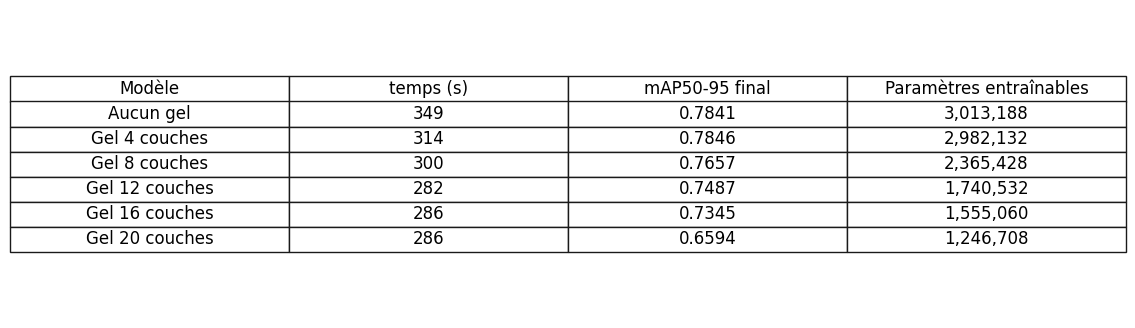

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Création d'un tableau comparatif
plt.figure(figsize=(12, 6))

# Dictionnaires pour stocker les données
time_data = {}
score_data = {}
trainable_params = {
    "Aucun gel": 3013188,
    "Gel 4 couches": 2982132,
    "Gel 8 couches": 2365428,
    "Gel 12 couches": 1740532,
    "Gel 16 couches": 1555060,
    "Gel 20 couches": 1246708
}

# Parcourir chaque dossier et extraire les données
for folder in folders:
    csv_path = os.path.join(base_path, folder, "results.csv")
    
    if os.path.exists(csv_path):
        # Lire le fichier CSV
        df = pd.read_csv(csv_path)
        
        # Extraire le temps d'exécution
        if 'time' in df.columns:
            # Prendre la valeur de temps à l'époque 20 (ou la dernière si moins de 20)
            max_epoch = min(20, len(df)) - 1  # -1 car les indices commencent à 0
            total_time = round(df['time'].iloc[max_epoch])  # Arrondi à la seconde
            
            # Stocker le temps total
            time_data[folder] = total_time
        
        # Extraire le score final
        map_column = next((col for col in ['metrics/mAP50-95(B)', 'metrics/mAP50(B)'] 
                          if col in df.columns), None)
        if map_column:
            final_score = df[map_column].iloc[-1]
            score_data[folder] = round(final_score, 4)

# Définir l'ordre logique des modèles (en fonction du nombre de couches gelées)
logical_order = [
    "Aucun gel",
    "Gel 4 couches", 
    "Gel 8 couches", 
    "Gel 12 couches", 
    "Gel 16 couches", 
    "Gel 20 couches"
]

# Filtrer les dossiers disponibles dans l'ordre logique
folders_to_display = [folder for folder in logical_order if folder in time_data and folder != "Toutes sauf la dernière"]

# Convertir en DataFrame pour l'affichage en tableau
time_df = pd.DataFrame({
    'Modèle': folders_to_display,
    'temps (s)': [time_data[folder] for folder in folders_to_display],
    'mAP50-95 final': [score_data.get(folder, "N/A") for folder in folders_to_display],
    'Paramètres entraînables': [trainable_params[folder] for folder in folders_to_display]
})

# Formater les nombres avec des séparateurs de milliers pour la lisibilité
time_df['Paramètres entraînables'] = time_df['Paramètres entraînables'].apply(lambda x: '{:,}'.format(x))

# Afficher le tableau dans la console
print("Temps d'exécution, scores et paramètres entraînables pour 20 époques:")
display(time_df)

# Créer une figure pour le tableau
fig, ax = plt.subplots(figsize=(12, len(folders_to_display) * 0.5 + 1))  # Largeur augmentée pour la nouvelle colonne
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=time_df.values, 
                 colLabels=time_df.columns,
                 loc='center', 
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Sauvegarder le tableau
plt.savefig("comparaison_temps_scores_params.png", dpi=300, bbox_inches='tight')
plt.show()

# Résultats Expérience 2: mAP50-95(B) en fonction du nombre d'époques pour différents modèles Yolov8n, DETR et RCNN:

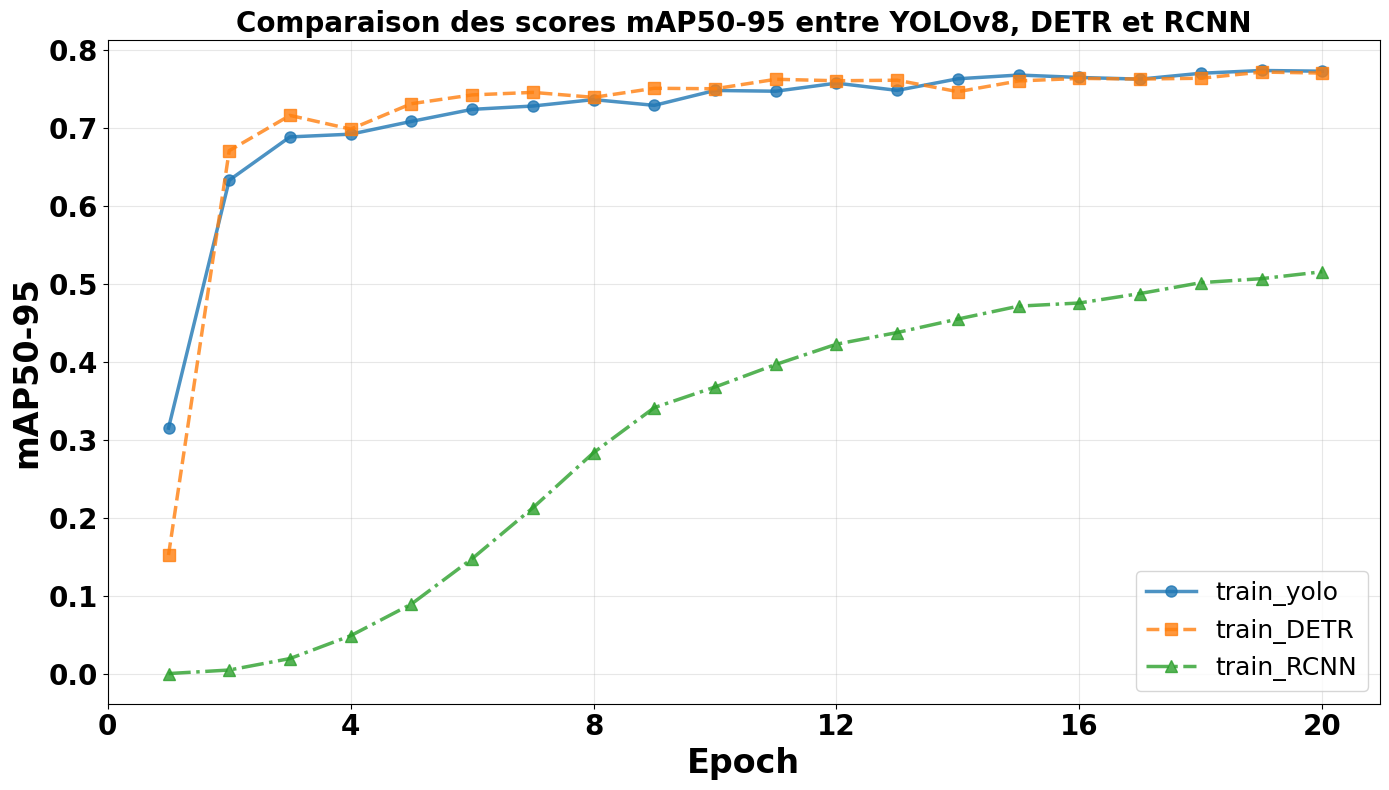

<Figure size 640x480 with 0 Axes>

In [60]:
# Résultats Expérience 2: mAP50-95 en fonction du nombre d'époques pour différents modèles:

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chemin vers le dossier principal contenant les résultats
base_path = "datasets/kaggle/runs_exp2/exp_2"

# Dictionnaire pour stocker les résultats
results = {}

# 1. Charger les données pour YOLOv8 et DETR depuis les CSV
for folder in ["train_yolo", "train_DETR"]:
    csv_path = os.path.join(base_path, folder, "results.csv")
    
    if os.path.exists(csv_path):
        # Lire le fichier CSV
        df = pd.read_csv(csv_path)
        
        # Extraire les 20 premières époques (ou toutes si moins de 20)
        max_epoch = min(20, len(df))
        epochs = df['epoch'][:max_epoch].tolist()
        
        # S'assurer que la colonne existe
        map_column = 'metrics/mAP50-95(B)' if 'metrics/mAP50-95(B)' in df.columns else 'metrics/mAP50(B)'
        
        if map_column in df.columns:
            map_scores = df[map_column][:max_epoch].tolist()
            
            # Stocker les résultats avec le nom du dossier comme clé
            results[folder] = (epochs, map_scores)
        else:
            print(f"Aucune colonne mAP trouvée dans {csv_path}")
            print(f"Colonnes disponibles: {df.columns.tolist()}")

# 2. Charger les données pour RCNN depuis le JSON
rcnn_json_path = os.path.join(base_path, "train_RCNN", "periodic_validation_results.json")

if os.path.exists(rcnn_json_path):
    with open(rcnn_json_path, 'r') as f:
        rcnn_data = json.load(f)
    
    # Trier les clés numériquement (en tant que nombres)
    sorted_keys = sorted([int(k) for k in rcnn_data.keys()])
    
    # Extraire les valeurs AP (mAP50-95) en sautant la première (0)
    rcnn_epochs = list(range(len(sorted_keys)))  # Convertir à 1-20
    rcnn_ap_values = [rcnn_data[str(k)]["bbox"]["AP"] for k in sorted_keys]
    
    # Stocker dans le dictionnaire de résultats
    results["train_RCNN"] = (np.array(rcnn_epochs)+1, np.array(rcnn_ap_values)/100)
else:
    print(f"Fichier JSON non trouvé: {rcnn_json_path}")

# Création du graphique
plt.figure(figsize=(14, 8))

# Définition de différents styles pour distinguer les courbes
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'x']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Tracé de chaque courbe
for i, (label, (epochs, scores)) in enumerate(results.items()):
    plt.plot(epochs, scores, linestyle=linestyles[i % len(linestyles)], 
             marker=markers[i % len(markers)], color=colors[i % len(colors)],
             alpha=0.8, linewidth=2.5, markersize=8, label=label)

# Paramètres de texte en gras et agrandis
plt.xlabel("Epoch", fontsize=24, fontweight='bold')
plt.ylabel("mAP50-95", fontsize=24, fontweight='bold')
plt.title("Comparaison des scores mAP50-95 entre YOLOv8, DETR et RCNN", fontsize=20, fontweight='bold')

# Configurer les ticks de l'axe x pour afficher les valeurs de 4 en 4
plt.xticks(np.arange(0, 21, 4), fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=18)
plt.grid(True, alpha=0.3)

# Affichage du graphique
plt.tight_layout()
plt.show()

# Sauvegarde de l'image
plt.savefig("comparaison_yolo_detr_rcnn_map.png", dpi=300)

Comparaison des modèles (temps d'exécution, score final et nombre de paramètres):


Modèle  Temps total (s)  mAP50-95 final  Paramètres
0    DETR             1787          0.7698  31,809,712
1    RCNN             4960          0.5152  41,477,536
2  YOLOv8              288          0.7722   3,000,692

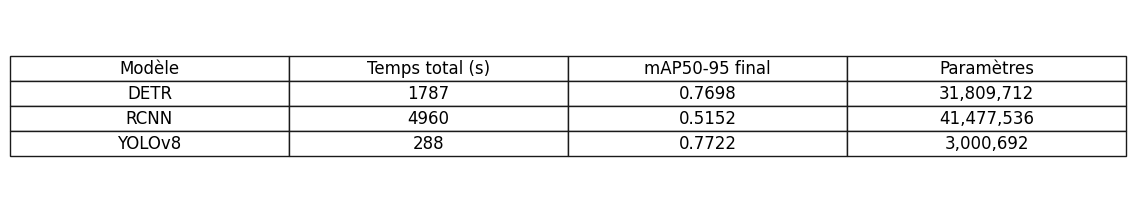

In [101]:
# Comparaison des temps d'exécution, scores et paramètres entre YOLOv8, DETR et RCNN

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chemin vers le dossier principal contenant les résultats
base_path = "datasets/kaggle/runs_exp2/exp_2"

# Liste des modèles à CSV (YOLOv8 et DETR)
csv_models = ["train_yolo", "train_DETR"]
# Noms d'affichage pour les modèles
model_display_names = {"train_yolo": "YOLOv8", "train_DETR": "DETR", "train_RCNN": "RCNN"}

# Dictionnaires pour stocker les résultats
times = {}
final_scores = {}

# Nombre de paramètres pour chaque modèle
model_parameters = {
    "YOLOv8": 3000692,
    "DETR": 31809712,
    "RCNN": 41477536
}

# Fonction pour extraire les données des modèles basés sur CSV
def process_csv_model(model_folder):
    csv_path = os.path.join(base_path, model_folder, "results.csv")
    model_name = model_display_names[model_folder]
    
    if not os.path.exists(csv_path):
        print(f"Fichier CSV non trouvé pour {model_name}: {csv_path}")
        return
        
    # Charger le CSV
    df = pd.read_csv(csv_path)
    
    # Extraire le temps à l'époque 20
    if 'time' in df.columns and 'epoch' in df.columns:
        epoch_20_rows = df[df['epoch'] == 20]
        if not epoch_20_rows.empty:
            time_value = round(float(epoch_20_rows['time'].iloc[0]))
            times[model_name] = time_value
    
    # Extraire le score final
    map_column = next((col for col in ['metrics/mAP50-95(B)', 'metrics/mAP50(B)'] 
                      if col in df.columns), None)
    if map_column:
        final_score = df[map_column].iloc[-1]
        final_scores[model_name] = round(final_score, 4)

# Traiter les modèles basés sur CSV
for model in csv_models:
    process_csv_model(model)

# Traiter le modèle RCNN séparément
def process_rcnn_model():
    model_name = model_display_names["train_RCNN"]
    
    # Extraire le temps depuis metrics.json
    rcnn_json_path = os.path.join(base_path, "train_RCNN", "metrics.json")
    if os.path.exists(rcnn_json_path):
        try:
            with open(rcnn_json_path, 'r') as f:
                first_line = f.readline().strip()
                rcnn_data = json.loads(first_line)
                
                if 'time' in rcnn_data:
                    rcnn_time = round(rcnn_data['time'] * 20 * 140)  # Facteur 140 comme dans le code original
                    times[model_name] = rcnn_time
        except Exception as e:
            print(f"Erreur lors de l'extraction du temps pour RCNN: {e}")
    
    # Extraire le score final depuis periodic_validation_results.json
    rcnn_val_path = os.path.join(base_path, "train_RCNN", "periodic_validation_results.json")
    if os.path.exists(rcnn_val_path):
        try:
            with open(rcnn_val_path, 'r') as f:
                rcnn_val_data = json.load(f)
                
                sorted_keys = sorted([int(k) for k in rcnn_val_data.keys()])
                if sorted_keys:
                    last_key = str(sorted_keys[-1])
                    ap_final = rcnn_val_data[last_key]["bbox"]["AP"]
                    final_scores[model_name] = round(ap_final / 100, 4)
        except Exception as e:
            print(f"Erreur lors de l'extraction du score final pour RCNN: {e}")

# Traiter RCNN
process_rcnn_model()

# Créer un DataFrame pour l'affichage en tableau
models = sorted(times.keys())  # Utiliser l'ordre des noms de modèles

# Préparer les données pour le tableau avec le nombre de paramètres
table_data = {
    'Modèle': models,
    'Temps total (s)': [times.get(model, "N/A") for model in models],
    'mAP50-95 final': [final_scores.get(model, "N/A") for model in models],
    'Paramètres': [f'{model_parameters[model]:,}' for model in models]  # Formatage avec séparateurs de milliers
}

time_df = pd.DataFrame(table_data)

# Afficher le tableau
print("Comparaison des modèles (temps d'exécution, score final et nombre de paramètres):")
display(time_df)

# Créer une figure pour le tableau
fig, ax = plt.subplots(figsize=(12, len(models) * 0.5 + 1))  # Augmenter la largeur pour la nouvelle colonne
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=time_df.values, 
                colLabels=time_df.columns,
                loc='center', 
                cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Mettre en évidence le nombre de paramètres avec des couleurs différentes
norm = plt.Normalize(min([model_parameters[m] for m in models]), 
                     max([model_parameters[m] for m in models]))
colors = plt.cm.Blues(norm([model_parameters[m] for m in models]))

# Ajouter une

In [99]:
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo

def load_rcnn_model():
    # Créer la configuration de base à partir du fichier YAML
    cfg = get_cfg()
    
    # Ajouter la configuration du modèle à partir du model_zoo
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.DEVICE = 'cpu'
    # Afficher le nombre total de paramètres du modèle
    def count_parameters(cfg):
        from detectron2.modeling import build_model
        
        # Construire le modèle à partir de la configuration
        model = build_model(cfg)
        
        # Compter les paramètres entraînables
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        return total_params
    total_params = count_parameters(cfg)
    print('total_params',total_params)
    print(f"Nombre total de paramètres entraînables: {total_params}")
    

# Exemple d'utilisation:
if __name__ == "__main__":
    # Remplacer par le chemin vers votre fichier de poids
    weights_path = "datasets\kaggle\runs_exp2\exp_2\train_RCNN\model_final.pth"
    
    # Charger le modèle
    load_rcnn_model()
print('dtr parameter ', 31809712)

total_params 41477536
Nombre total de paramètres entraînables: 41477536
dtr parameter  31809712


# Résultats Expérience 3: mAP50-95(B) en fonction du nombre d'époques pour pré-finetuning sur un autre jeu de données:


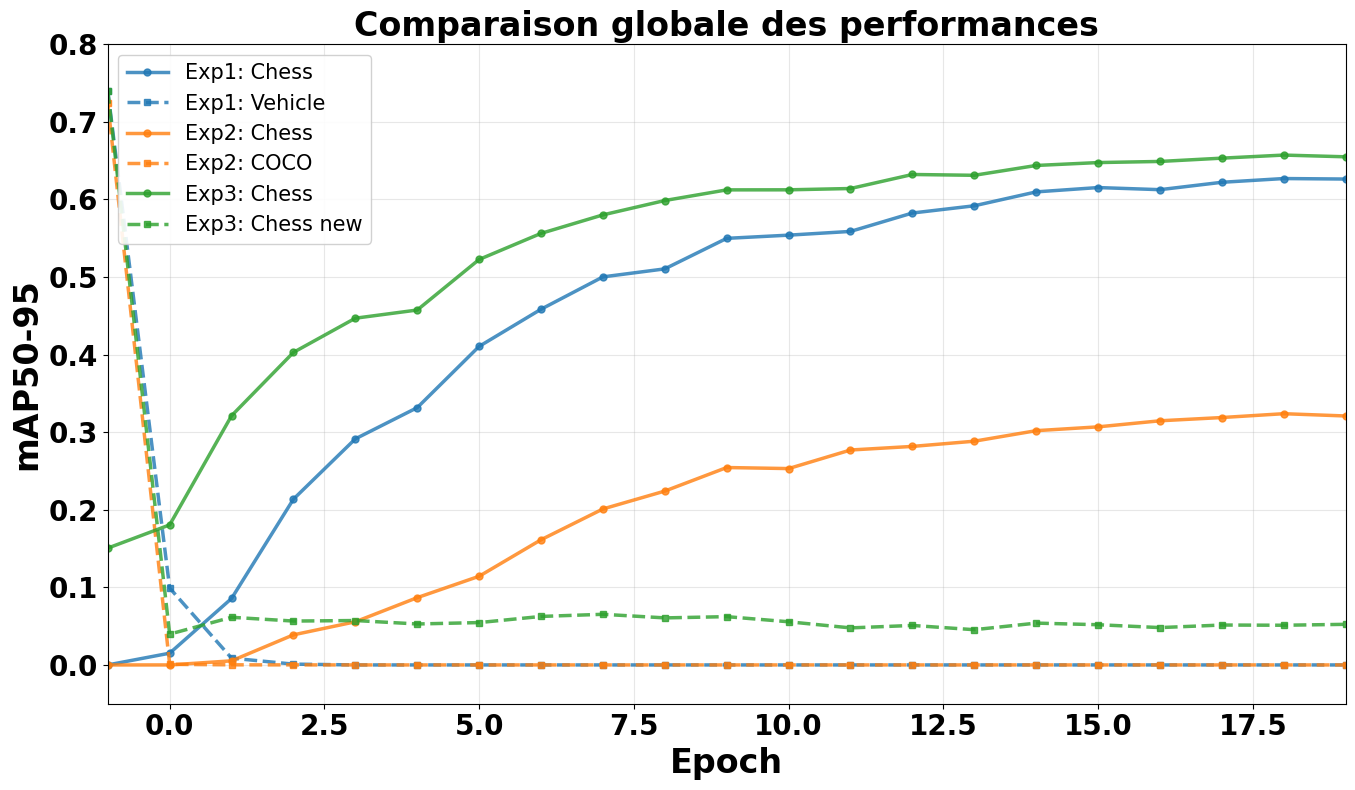

In [102]:
# Comparaison globale des performances des différentes expériences

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger les données
df = pd.read_csv("datasets/kaggle/exp_3comparaison_performances.csv")

# Définir les couleurs pour chaque expérience
colors = {'exp1': '#1f77b4', 'exp2': '#ff7f0e', 'exp3': '#2ca02c'}

plt.figure(figsize=(14, 8))

# Expérience 1
plt.plot(df['epoch'], df['chess_exp1'], color=colors['exp1'], linestyle='-',  # Trait plein pour chess
         linewidth=2.5, marker='o', markersize=5, alpha=0.8, label="Exp1: Chess")
plt.plot(df['epoch'], df['vehicle_exp1'], color=colors['exp1'], linestyle='--',  # Trait pointillé pour non-chess
         linewidth=2.5, marker='s', markersize=5, alpha=0.8, label="Exp1: Vehicle")

# Expérience 2
plt.plot(df['epoch'], df['chess_exp2'], color=colors['exp2'], linestyle='-',  # Trait plein pour chess
         linewidth=2.5, marker='o', markersize=5, alpha=0.8, label="Exp2: Chess")
plt.plot(df['epoch'], df['coco_exp2'], color=colors['exp2'], linestyle='--',  # Trait pointillé pour non-chess
         linewidth=2.5, marker='s', markersize=5, alpha=0.8, label="Exp2: COCO")

# Expérience 3
plt.plot(df['epoch'], df['chess_exp3'], color=colors['exp3'], linestyle='-',  # Trait plein pour chess
         linewidth=2.5, marker='o', markersize=5, alpha=0.8, label="Exp3: Chess")
plt.plot(df['epoch'], df['chess_test_exp3'], color=colors['exp3'], linestyle='--',  # Trait pointillé pour chess new
         linewidth=2.5, marker='s', markersize=5, alpha=0.8, label="Exp3: Chess new")

# Paramètres de texte
plt.xlabel("Epoch", fontsize=24, fontweight='bold')
plt.ylabel("mAP50-95", fontsize=24, fontweight='bold')
plt.title("Comparaison globale des performances", fontsize=24, fontweight='bold')

# Agrandir et mettre en gras les nombres sur les axes
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

# Améliorer la légende
plt.legend(loc='upper left', fontsize=15, framealpha=0.9)

# Ajouter une grille et optimiser l'espace
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Limites des axes
plt.xlim(-1, 19)  # Ajuster selon les données
plt.ylim(-0.05, 0.8)  # Ajuster selon les données

# Sauvegarder et afficher
plt.savefig("comparaison_globale_performances.png", dpi=300, bbox_inches='tight')
plt.show()

Comparaison des performances avant et après finetuning:


Jeu de données  mAP50-95 après pré-finetuning  \
0          Exp1: Chess                         0.0000   
1        Exp1: Vehicle                         0.7399   
2          Exp2: Chess                         0.0000   
3           Exp2: COCO                         0.7240   
4  Exp3: Chess (train)                         0.1506   
5   Exp3: Chess (test)                         0.7399   

   mAP50-95 après finetuning    Gain  
0                     0.6263  0.6263  
1                     0.0000 -0.7399  
2                     0.3209  0.3209  
3                     0.0000 -0.7240  
4                     0.6550  0.5044  
5                     0.0523 -0.6875

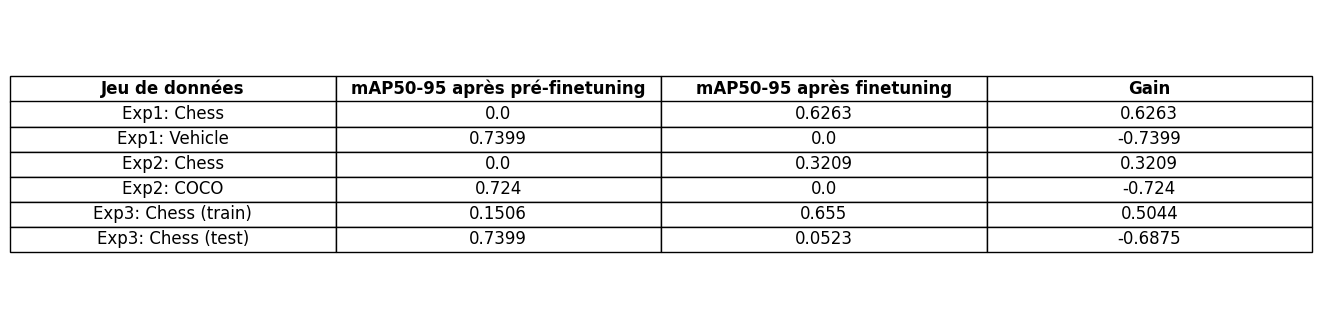

In [27]:
# Tableau comparatif des performances avant et après finetuning

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger les données
df = pd.read_csv("datasets/kaggle/exp_3comparaison_performances.csv")

# Extraire les premières et dernières valeurs pour chaque colonne
columns = ['chess_exp1', 'vehicle_exp1', 'chess_exp2', 'coco_exp2', 'chess_exp3', 'chess_test_exp3']
column_display_names = {
    'chess_exp1': 'Exp1: Chess',
    'vehicle_exp1': 'Exp1: Vehicle',
    'chess_exp2': 'Exp2: Chess',
    'coco_exp2': 'Exp2: COCO',
    'chess_exp3': 'Exp3: Chess (train)',
    'chess_test_exp3': 'Exp3: Chess (test)'
}

# Créer un dictionnaire pour les données du tableau
table_data = {
    'Jeu de données': [column_display_names[col] for col in columns],
    'mAP50-95 après pré-finetuning': [round(df[col].iloc[0], 4) for col in columns],
    'mAP50-95 après finetuning': [round(df[col].iloc[-1], 4) for col in columns],
    'Gain': [round(df[col].iloc[-1] - df[col].iloc[0], 4) for col in columns]
}

# Créer le DataFrame
results_df = pd.DataFrame(table_data)

# Afficher le tableau
print("Comparaison des performances avant et après finetuning:")
display(results_df)

# Créer une figure pour le tableau
fig, ax = plt.subplots(figsize=(14, len(columns) * 0.5 + 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, 
                 colLabels=results_df.columns,
                 loc='center', 
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
for i, key in enumerate(table._cells):
    if key[0] == 0:  # Les en-têtes de colonne
        table._cells[key].set_text_props(fontweight='bold')

# Sauvegarder le tableau
plt.savefig("comparaison_avant_apres_finetuning.png", dpi=300, bbox_inches='tight')
plt.show()


image 1/1 c:\Users\levovo pro p50\Documents\informatique\MALIA\Recent advance in IA\datasets\Chess_data_test_last\valid\images\20230315_192007_jpg.rf.679f7cb5e059b8b186db8e0afe6bcb75.jpg: 640x640 2 black-knights, 10 black-pawns, 1 black-queen, 2 black-rooks, 1 white-knight, 9 white-pawns, 3 white-queens, 2 white-rooks, 150.9ms
Speed: 6.3ms preprocess, 150.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


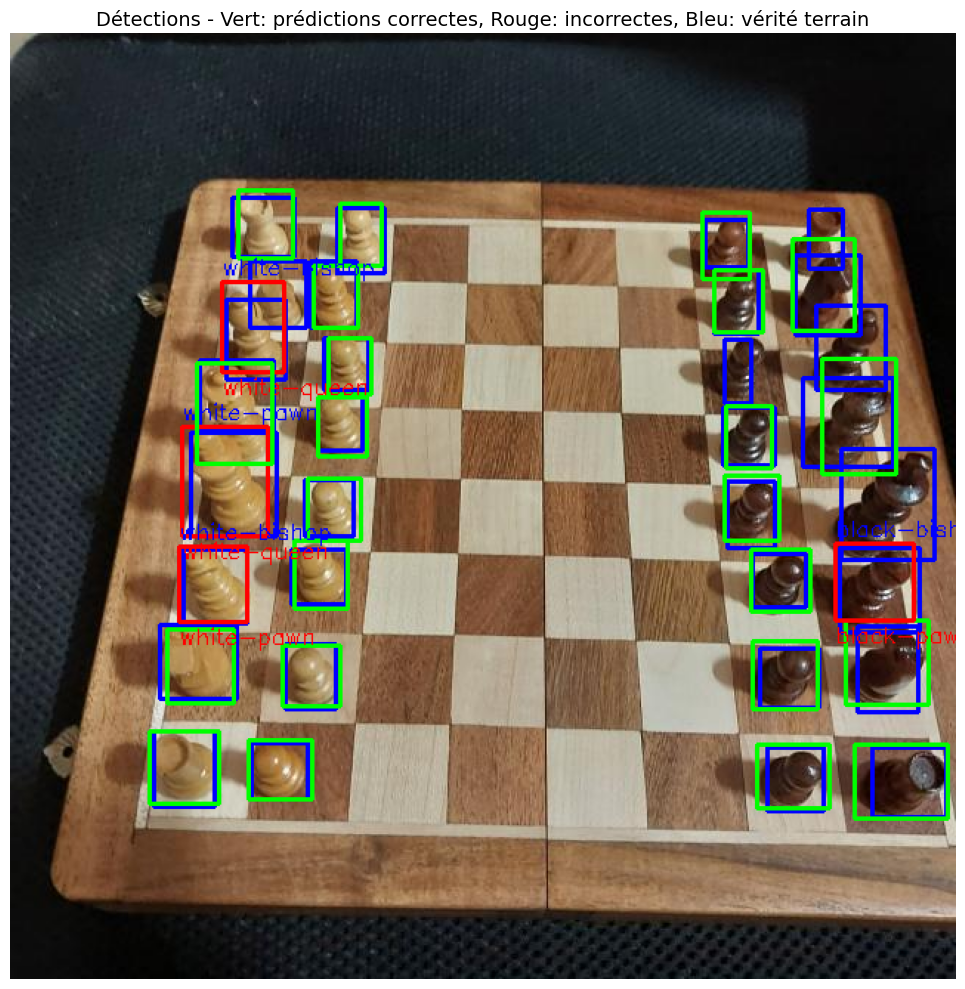

In [119]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def iou(boxA, boxB):
    """
    Calcule l'IoU (Intersection over Union) entre deux boîtes au format [x1, y1, x2, y2].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    if boxAArea == 0 or boxBArea == 0:
        return 0.0
    iou_val = interArea / float(boxAArea + boxBArea - interArea)
    return iou_val

def read_ground_truth_boxes(image_path):
    """
    Lit les boîtes réelles (ground truth) pour l'image spécifiée.
    Renvoie une liste de tuples (class_id, x1, y1, x2, y2) en coordonnées pixels.
    """
    filename_no_ext = os.path.splitext(os.path.basename(image_path))[0]
    # Construire le chemin vers le fichier de label correspondant
    label_dir = os.path.join(os.path.dirname(os.path.dirname(image_path)), "labels")
    label_file = os.path.join(label_dir, filename_no_ext + ".txt")
    
    if not os.path.exists(label_file):
        print(f"Fichier d'annotation non trouvé: {label_file}")
        return []
    
    # Lecture de l'image pour obtenir largeur/hauteur en pixels
    img_bgr = cv2.imread(image_path)
    h, w, _ = img_bgr.shape

    boxes = []
    with open(label_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id = int(parts[0])  # Classe GT originale
            x_c = float(parts[1])
            y_c = float(parts[2])
            bw = float(parts[3])
            bh = float(parts[4])
            # Conversion YOLO -> xyxy (en pixels)
            x1 = int((x_c - bw/2) * w)
            y1 = int((y_c - bh/2) * h)
            x2 = int((x_c + bw/2) * w)
            y2 = int((y_c + bh/2) * h)
            boxes.append((class_id, x1, y1, x2, y2))
    return boxes

# Mapping des classes GT vers les classes du modèle
class_mapping = {
    0: 0,   # black-camel -> black-bishop
    1: 5,   # black-elephant -> black-rook
    2: 2,   # black-horse -> black-knight
    3: 1,   # black-king -> black-king
    4: 3,   # black-pawn -> black-pawn
    5: 4,   # black-queen -> black-queen
    6: 6,   # white-camel -> white-bishop
    7: 11,  # white-elephant -> white-rook
    8: 8,   # white-horse -> white-knight
    9: 7,   # white-king -> white-king
    10: 9,  # white-pawn -> white-pawn
    11: 10, # white-queen -> white-queen
}

# Définition des noms des classes originales (GT)
gt_class_names =  ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']
# 1. Chargement du modèle avec les poids spécifiés
weights_path = r"datasets\kaggle\run_chess\phase1\chess_test_pretraining7\weights\best.pt"
model = YOLO(weights_path)

# 2. Chemin vers l'image à analyser
image_path = r"datasets\Chess_data_test_last\valid\images\20230315_192007_jpg.rf.679f7cb5e059b8b186db8e0afe6bcb75.jpg"

# Vérifier que les fichiers existent
if not os.path.exists(weights_path) or not os.path.exists(image_path):
    print(f"ERREUR: Fichier non trouvé")
else:
    # 3. Prédiction sur l'image
    results = model.predict(image_path, conf=0.25)[0]  # Premier résultat
    
    # 4. Récupérer les annotations réelles
    gt_boxes = read_ground_truth_boxes(image_path)
    
    # 5. Charger l'image et préparer l'affichage
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 6. Récupérer les noms de classes du modèle
    model_class_names = model.names if hasattr(model, 'names') else None
    
    # 7. Filtrer les prédictions valides (avec label)
    valid_pred_boxes = []
    for i, box in enumerate(results.boxes):
        if hasattr(box, 'cls') and len(box.cls) > 0:
            valid_pred_boxes.append((i, box))
    
    # 8. Pour chaque GT, trouver la meilleure prédiction
    used_pred_indices = set()  # Prédictions déjà utilisées
    gt_pred_matches = []  # Stocke les tuples (gt_idx, pred_idx, iou_val)
    
    for gt_idx, (gt_class, x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
        best_iou = 0.0
        best_pred_idx = -1
        
        for pred_idx, box in valid_pred_boxes:
            # Calculer IoU
            x1p, y1p, x2p, y2p = box.xyxy[0]
            pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
            current_iou = iou(pred_box_xyxy, [x1_gt, y1_gt, x2_gt, y2_gt])
            
            # Mettre à jour si meilleur IoU
            if current_iou > best_iou:
                best_iou = current_iou
                best_pred_idx = pred_idx
        
        # Si on a trouvé une prédiction avec IoU suffisant
        if best_iou >= 0.5 and best_pred_idx != -1:
            gt_pred_matches.append((gt_idx, best_pred_idx, best_iou))
            used_pred_indices.add(best_pred_idx)
    
    # 9. Dessiner les boîtes GT en BLEU
    for gt_idx, (cls_id, x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
        cv2.rectangle(img_rgb, (x1_gt, y1_gt), (x2_gt, y2_gt), (0, 0, 255), 2)  # Bleu en RGB
    
    # 10. Dessiner les meilleures prédictions pour chaque GT
    for gt_idx, pred_idx, _ in gt_pred_matches:
        # Récupérer les infos de la GT
        gt_class, _, _, _, _ = gt_boxes[gt_idx]
        mapped_gt_class = class_mapping.get(gt_class, -1)
        
        # Récupérer les infos de la prédiction
        box = results.boxes[pred_idx]
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [int(float(x1p)), int(float(y1p)), int(float(x2p)), int(float(y2p))]
        pred_class = int(box.cls[0])
        pred_label = model_class_names[pred_class] if model_class_names else f"C{pred_class}"
        
        # Vérifier si la prédiction est correcte
        if pred_class == mapped_gt_class:
            # Prédiction correcte - VERT
            color = (0, 255, 0)
            # Pas de label pour les prédictions correctes
        else:
            # Prédiction avec mauvaise classe - ROUGE
            color = (255, 0, 0)
            # Afficher le vrai label (en bleu) et le label prédit (en rouge)
            gt_label = gt_class_names[gt_class] if gt_class < len(gt_class_names) else f"C{gt_class}"
            cv2.putText(img_rgb, gt_label, (pred_box_xyxy[0], pred_box_xyxy[1]-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.putText(img_rgb, pred_label, (pred_box_xyxy[0], pred_box_xyxy[3]+15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Dessiner la boîte de prédiction
        cv2.rectangle(img_rgb, 
                     (pred_box_xyxy[0], pred_box_xyxy[1]),
                     (pred_box_xyxy[2], pred_box_xyxy[3]),
                     color, 2)
    
    # 11. Dessiner les faux positifs (prédictions non associées à une GT)
    for pred_idx, box in valid_pred_boxes:
        if pred_idx not in used_pred_indices:
            x1p, y1p, x2p, y2p = box.xyxy[0]
            pred_box_xyxy = [int(float(x1p)), int(float(y1p)), int(float(x2p)), int(float(y2p))]
            pred_class = int(box.cls[0])
            pred_label = model_class_names[pred_class] if model_class_names else f"C{pred_class}"
            
        
    # 12. Afficher l'image avec les annotations
    plt.figure(figsize=(12, 10))
    plt.imshow(img_rgb)
    plt.title("Détections - Vert: prédictions correctes, Rouge: incorrectes, Bleu: vérité terrain", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


image 1/1 c:\Users\levovo pro p50\Documents\informatique\MALIA\Recent advance in IA\datasets\Chess_data\valid\images\1be2a621f309c7482e9a79ad5b23ecbe_jpg.rf.70e600317a251d79d4ba9a1113340163.jpg: 640x640 1 black-bishop, 1 black-king, 1 black-pawn, 1 black-rook, 2 white-kings, 1 white-knight, 1 white-rook, 297.0ms
Speed: 6.6ms preprocess, 297.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


3
3
7
6
7
7
0
0


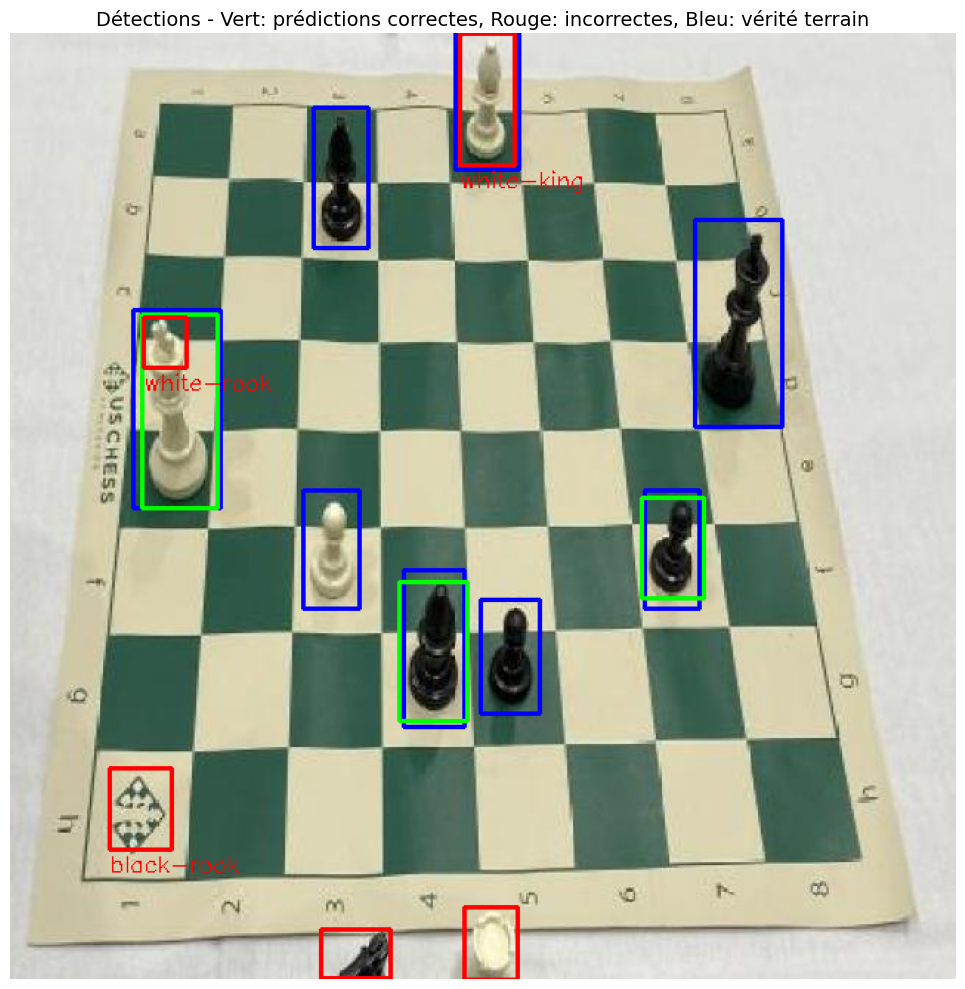

In [127]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

class_mapping = {
    0: 0,   # black-bishop -> black-camel
    5: 1,   # black-rook -> black-elephant
    2: 2,   # black-knight -> black-horse
    1: 3,   # black-king -> black-king
    3: 4,   # black-pawn -> black-pawn
    4: 5,   # black-queen -> black-queen
    6: 6,   # white-bishop -> white-camel
    11: 7,  # white-rook -> white-elephant
    8: 8,   # white-knight -> white-horse
    7: 9,   # white-king -> white-king
    9: 10,  # white-pawn -> white-pawn
    10: 11, # white-queen -> white-queen
}

# 2. Chemin vers la nouvelle image à analyser
image_path = r"datasets\Chess_data\valid\images\1be2a621f309c7482e9a79ad5b23ecbe_jpg.rf.70e600317a251d79d4ba9a1113340163.jpg"
# Mapping des classes GT vers les classes du modèle
class_mapping = {
    0: 0,   # black-camel -> black-bishop
    1: 5,   # black-elephant -> black-rook
    2: 2,   # black-horse -> black-knight
    3: 1,   # black-king -> black-king
    4: 3,   # black-pawn -> black-pawn
    5: 4,   # black-queen -> black-queen
    6: 6,   # white-camel -> white-bishop
    7: 11,  # white-elephant -> white-rook
    8: 8,   # white-horse -> white-knight
    9: 7,   # white-king -> white-king
    10: 9,  # white-pawn -> white-pawn
    11: 10, # white-queen -> white-queen
}

# Vérifier que les fichiers existent
if not os.path.exists(weights_path) or not os.path.exists(image_path):
    print(f"ERREUR: Fichier non trouvé")
else:
    # 3. Prédiction sur l'image
    results = model.predict(image_path, conf=0.25)[0]  # Premier résultat
    
    # 4. Récupérer les annotations réelles
    gt_boxes = read_ground_truth_boxes(image_path)
    
    # 5. Charger l'image et préparer l'affichage
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 6. Récupérer les noms de classes du modèle
    model_class_names = model.names if hasattr(model, 'names') else None
    
    # 7. Filtrer les prédictions valides (avec label)
    valid_pred_boxes = []
    for i, box in enumerate(results.boxes):
        if hasattr(box, 'cls') and len(box.cls) > 0:
            valid_pred_boxes.append((i, box))
    
    # 8. Pour chaque GT, trouver la meilleure prédiction
    used_pred_indices = set()  # Prédictions déjà utilisées
    gt_pred_matches = []  # Stocke les tuples (gt_idx, pred_idx, iou_val)
    
    for gt_idx, (gt_class, x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
        best_iou = 0.0
        best_pred_idx = -1
        
        for pred_idx, box in valid_pred_boxes:
            # Calculer IoU
            x1p, y1p, x2p, y2p = box.xyxy[0]
            pred_box_xyxy = [float(x1p), float(y1p), float(x2p), float(y2p)]
            current_iou = iou(pred_box_xyxy, [x1_gt, y1_gt, x2_gt, y2_gt])
            
            # Mettre à jour si meilleur IoU
            if current_iou > best_iou:
                best_iou = current_iou
                best_pred_idx = pred_idx
        
        # Si on a trouvé une prédiction avec IoU suffisant
        if best_iou >= 0.5 and best_pred_idx != -1:
            gt_pred_matches.append((gt_idx, best_pred_idx, best_iou))
            used_pred_indices.add(best_pred_idx)
    
    # 9. Dessiner les boîtes GT en BLEU
    for gt_idx, (cls_id, x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
        cv2.rectangle(img_rgb, (x1_gt, y1_gt), (x2_gt, y2_gt), (0, 0, 255), 2)  # Bleu en RGB
    
    # 10. Dessiner les meilleures prédictions pour chaque GT
    for gt_idx, pred_idx, _ in gt_pred_matches:
        # Récupérer les infos de la GT
        gt_class, _, _, _, _ = gt_boxes[gt_idx]
        mapped_gt_class = gt_class
        
        # Récupérer les infos de la prédiction
        box = results.boxes[pred_idx]
        x1p, y1p, x2p, y2p = box.xyxy[0]
        pred_box_xyxy = [int(float(x1p)), int(float(y1p)), int(float(x2p)), int(float(y2p))]
        pred_class = int(box.cls[0])
        pred_label = model_class_names[pred_class] if model_class_names else f"C{pred_class}"
        
        # Vérifier si la prédiction est correcte
        print(pred_class)
        print(mapped_gt_class)
        if pred_class == mapped_gt_class:
            # Prédiction correcte - VERT
            color = (0, 255, 0)
            # Pas de label pour les prédictions correctes
        else:
            # Prédiction avec mauvaise classe - ROUGE
            color = (255, 0, 0)
            # Afficher le vrai label (en bleu) et le label prédit (en rouge)
            gt_label = gt_class_names[gt_class] if gt_class < len(gt_class_names) else f"C{gt_class}"
            cv2.putText(img_rgb, gt_label, (pred_box_xyxy[0], pred_box_xyxy[1]-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.putText(img_rgb, pred_label, (pred_box_xyxy[0], pred_box_xyxy[3]+15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Dessiner la boîte de prédiction
        cv2.rectangle(img_rgb, 
                     (pred_box_xyxy[0], pred_box_xyxy[1]),
                     (pred_box_xyxy[2], pred_box_xyxy[3]),
                     color, 2)
    
    # 11. Dessiner les faux positifs (prédictions non associées à une GT)
    for pred_idx, box in valid_pred_boxes:
        if pred_idx not in used_pred_indices:
            x1p, y1p, x2p, y2p = box.xyxy[0]
            pred_box_xyxy = [int(float(x1p)), int(float(y1p)), int(float(x2p)), int(float(y2p))]
            pred_class = int(box.cls[0])
            pred_label = model_class_names[pred_class] if model_class_names else f"C{pred_class}"
            
            # Prédiction qui ne correspond à aucune GT (faux positif) - ROUGE
            color = (255, 0, 0)
            # Afficher le label prédit
            cv2.putText(img_rgb, pred_label, (pred_box_xyxy[0], pred_box_xyxy[3]+15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            # Dessiner la boîte de prédiction
            cv2.rectangle(img_rgb, 
                         (pred_box_xyxy[0], pred_box_xyxy[1]),
                         (pred_box_xyxy[2], pred_box_xyxy[3]),
                         color, 2)
    
    # 12. Afficher l'image avec les annotations
    plt.figure(figsize=(12, 10))
    plt.imshow(img_rgb)
    plt.title("Détections - Vert: prédictions correctes, Rouge: incorrectes, Bleu: vérité terrain", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()